<a href="https://colab.research.google.com/github/jacr2006/AICamera/blob/master/Notebooks/CNN/data_trainning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook extract mid-term features from labeled audio files (.wav), and create a matrix of features and a vector of classes. Next, a trainning using a CNN is done. The model obtained is used for testing.

In [1]:
!pip install torchaudio

     |████████████████████████████████| 7.6MB 13.5MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [2]:
import torchaudio.transforms
import torch

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import IPython.display as ipd

import shutil

import librosa

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import preprocessing

import pickle

from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# source file directory
PATH_DRIVE = '/content/drive/MyDrive/Colab Notebooks/'

## Training

In [6]:
f_train = np.load(PATH_DRIVE + "f_train.npy", allow_pickle=True)
f_avg_train = np.load(PATH_DRIVE + "f_avg_train.npy", allow_pickle=True)
c_train = np.load(PATH_DRIVE + "c_train.npy", allow_pickle=True)

f_val = np.load(PATH_DRIVE + "f_val.npy", allow_pickle=True)
f_avg_val = np.load(PATH_DRIVE + "f_avg_val.npy", allow_pickle=True)
c_val = np.load(PATH_DRIVE + "c_val.npy", allow_pickle=True)

In [8]:
print( f_train.shape )
print( f_val.shape )

(1200, 345, 40)
(216, 345, 40)


In [ ]:
#from sklearn.preprocessing import StandardScaler

#ss = StandardScaler()
#f_train = ss.fit_transform(f_train.reshape(-1, f_train.shape[-1])).reshape(f_train.shape)

In [ ]:
#data standarization
#ff = preprocessing.scale(f)

#data scalling (min-max) for improve prediction accurancy
#min_max_scaler = preprocessing.MinMaxScaler()
#ff = min_max_scaler.fit_transform( f.reshape(-1, f.shape[-1]) ).reshape(f.shape)

In [ ]:
#ff.shape

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.regularizers import l2

# Encode the classification labels to one-hot
le = LabelEncoder()
cc_train = to_categorical(le.fit_transform(c_train)) 
print( cc_train.shape )

cc_val = to_categorical(le.fit_transform(c_val)) 
print( cc_val.shape )

(1200, 4)
(216, 4)


In [12]:
# Classes according Urban Dataset
num_classes = 4

In [69]:
# Training and test split 
# X_train, X_test, y_train, y_test = train_test_split(f, cc, test_size=0.05,random_state=0) # 95% for training - 5% for  testing
X_train, X_val, y_train, y_val = f_train, f_val, cc_train, cc_val

In [70]:
print( X_train.shape )
print( X_val.shape )

(1200, 345, 40)
(216, 345, 40)


In [71]:
# Model


# cnn model
'''
input_shape = ( X_train.shape[1], X_train.shape[2], 1  )

X_train = np.expand_dims(X_train, axis=3)
print( X_train.shape )
X_val = np.expand_dims(X_val, axis=3)
print( X_val.shape )

model =  keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes, activation='softmax'))
'''

pool_size = (2, 2)
kernel_size = (3, 3)

input_shape = ( X_train.shape[1], X_train.shape[2], 1  )

X_train = np.expand_dims(X_train, axis=3)
print( X_train.shape )
X_val = np.expand_dims(X_val, axis=3)
print( X_val.shape )

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(128, kernel_size=kernel_size, padding="same", input_shape=input_shape))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

model.add(keras.layers.Conv2D(28, kernel_size=kernel_size, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

model.add(keras.layers.Conv2D(256, kernel_size=kernel_size, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

model.add(keras.layers.Conv2D(256, kernel_size=kernel_size, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))

model.add(keras.layers.GlobalMaxPooling2D())
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(num_classes, activation="softmax"))


'''
# LSTM model
#X_train = np.expand_dims(X_train, axis=3)
print( X_train.shape )
#X_val = np.expand_dims(X_val, axis=3)
print( X_val.shape )

input_shape = ( X_train.shape[1], X_train.shape[2]  )

model = keras.Sequential()
model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=False))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes, activation='softmax'))
'''

'''
# mix model

input_cnn = ( X_train.shape[1], X_train.shape[2], 1  )
input_lstm = ( X_train.shape[1], X_train.shape[2]  )

X_train_c = np.expand_dims(X_train, axis=3)
print( X_train.shape )
X_val_c = np.expand_dims(X_val, axis=3)
print( X_val.shape )


cnn_in = keras.Input(shape=input_cnn)
x = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_in)
x = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.15)(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.20)(x)
cnn_model = keras.layers.Flatten()(x)

rnn_in = keras.Input(shape=input_lstm)
x = keras.layers.LSTM(256, return_sequences=False)(rnn_in)
x = keras.layers.Dropout(0.20)(x)
rnn_model = keras.layers.Flatten()(x)

x = keras.layers.Concatenate()([cnn_model, rnn_model])

x = keras.layers.Dense(1024)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)
conc_model = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=[cnn_in, rnn_in], outputs=conc_model)

# for fit input, use
# history = model.fit( [X_train_c, X_train], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2 )
'''


(1200, 345, 40, 1)
(216, 345, 40, 1)


"\n# mix model\n\ninput_cnn = ( X_train.shape[1], X_train.shape[2], 1  )\ninput_lstm = ( X_train.shape[1], X_train.shape[2]  )\n\nX_train_c = np.expand_dims(X_train, axis=3)\nprint( X_train.shape )\nX_val_c = np.expand_dims(X_val, axis=3)\nprint( X_val.shape )\n\n\ncnn_in = keras.Input(shape=input_cnn)\nx = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_in)\nx = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)\nx = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)\nx = keras.layers.Dropout(0.15)(x)\nx = keras.layers.Conv2D(128, kernel_size=3, activation='relu')(x)\nx = keras.layers.Conv2D(128, kernel_size=3, activation='relu')(x)\nx = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)\nx = keras.layers.Dropout(0.20)(x)\ncnn_model = keras.layers.Flatten()(x)\n\nrnn_in = keras.Input(shape=input_lstm)\nx = keras.layers.LSTM(256, return_sequences=False)(rnn_in)\nx = keras.layers.Dropout(0.20)(x)\nrnn_model = keras.layers.Flatten()(x)\n\nx = keras.layers.Concatenate(

In [72]:
batch_size = 16
epochs = 10
opt = keras.optimizers.Adam( learning_rate=0.0001 )
model.compile( loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"] )
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 345, 40, 128)      1280      
_________________________________________________________________
batch_normalization_16 (Batc (None, 345, 40, 128)      512       
_________________________________________________________________
activation_16 (Activation)   (None, 345, 40, 128)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 172, 20, 128)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 172, 20, 28)       32284     
_________________________________________________________________
batch_normalization_17 (Batc (None, 172, 20, 28)       112       
_________________________________________________________________
activation_17 (Activation)   (None, 172, 20, 28)      

In [73]:
history = model.fit( X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), shuffle=True )

Epoch 1/10
75/75 [==============================] - 3s 29ms/step - loss: 0.9755 - accuracy: 0.6605 - val_loss: 1.0309 - val_accuracy: 0.6111
Epoch 2/10
75/75 [==============================] - 2s 25ms/step - loss: 0.2327 - accuracy: 0.9327 - val_loss: 0.7299 - val_accuracy: 0.7593
Epoch 3/10
75/75 [==============================] - 2s 26ms/step - loss: 0.1272 - accuracy: 0.9679 - val_loss: 0.4984 - val_accuracy: 0.8287
Epoch 4/10
75/75 [==============================] - 2s 25ms/step - loss: 0.1133 - accuracy: 0.9641 - val_loss: 0.4158 - val_accuracy: 0.8796
Epoch 5/10
75/75 [==============================] - 2s 25ms/step - loss: 0.0741 - accuracy: 0.9722 - val_loss: 0.3874 - val_accuracy: 0.8750
Epoch 6/10
75/75 [==============================] - 2s 26ms/step - loss: 0.0399 - accuracy: 0.9901 - val_loss: 0.3732 - val_accuracy: 0.8704
Epoch 7/10
75/75 [==============================] - 2s 26ms/step - loss: 0.0359 - accuracy: 0.9927 - val_loss: 0.5068 - val_accuracy: 0.8565
Epoch 8/10
75

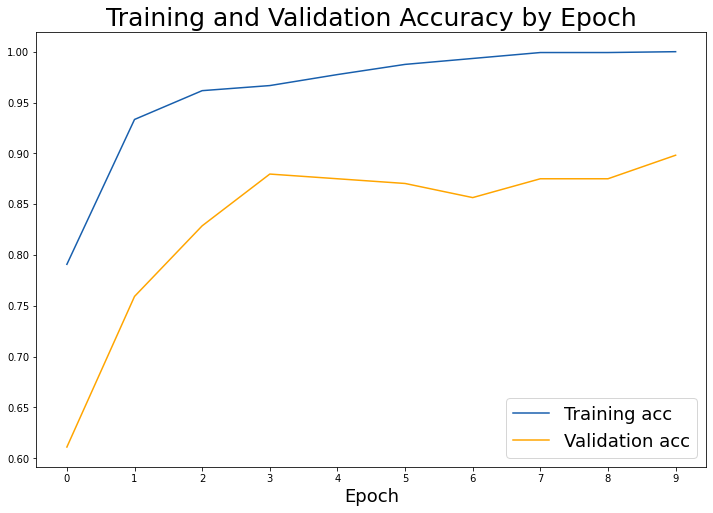

In [76]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Set figure size.
plt.figure(figsize=(12, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training acc', color='#185fad')
plt.plot(val_accuracy, label='Validation acc', color='orange')
# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(range(0,10,1), range(0,10,1))
plt.legend(fontsize = 18);

In [77]:
# Save model for inference
model.save(PATH_DRIVE+'audio_classificator_cnn_model_v2.h5')